In [2]:
import os
import sys 
import matplotlib.pyplot as plt 
import minari 
import numpy as np
import faiss
import torch 

from models.cmhn import cmhn
from models.beta_model import LearnedBetaModel
from models.cl_model import mlpCL

from utils import visualizations
from utils import cmhn_utils
from utils.sampling_states import sample_states
from utils import pca 

In [3]:
# Resolving some weird faiss issues
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)
faiss.omp_set_num_threads(1)

# Solves a faiss issue with macbooks
sys.modules['faiss.swigfaiss_avx2'] = faiss

In [4]:
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
DEVICE = "cpu"
PROJECT_ROOT = os.getcwd()
TOTAL_STATES = 10_000

mhn = cmhn(update_steps=3, device=DEVICE)


In [5]:
states_d = sample_states(MINARI_DATASET, TOTAL_STATES)

In [6]:
cl_model_name = "laplace.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", cl_model_name) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    laplace_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))

bm_model_name = "beta_model.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", bm_model_name) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    beta_model = LearnedBetaModel.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE), 
                                                          cmhn = mhn, 
                                                          device=DEVICE,
                                                          )

Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\laplace.ckpt, loading...
Found pretrained model at c:\Users\ray\Documents\2025 RA\contrastive-learning-RL/best_models\beta_model.ckpt, loading...


In [7]:
states = states_d["states"]

# Get z representations
with torch.no_grad(): 
    z = laplace_model(torch.as_tensor(states, dtype=torch.float32))

# Get u representation
with torch.no_grad(): 
    beta = beta_model.get_beta(z)
    u, u_norm = mhn.run(z, z, beta, run_as_batch=True)

# Remove duplicate/similar U values
unique_mask = cmhn_utils.remove_dupes(u_norm, k=10000, threshold=0.7)
unique_u = u[unique_mask]

In [8]:
# Visualization portion 

pca_dict = pca.process_states(states, laplace_model)
pca_u = pca.pca_transform(unique_u, pca_dict, laplace_model, has_representation=True)
pca_z = pca_dict["pca-reps"]

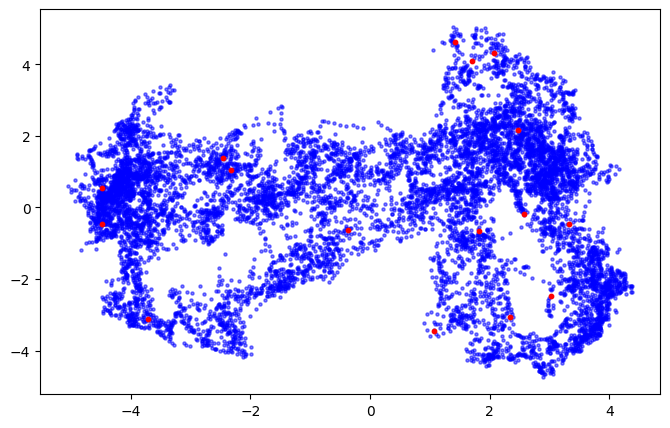

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
axs.scatter(x=pca_z[:, 0], y = pca_z[:, 1], c="blue", s=5, alpha=0.5)
axs.scatter(x=pca_u[:, 0], y = pca_u[:, 1], c="red", s= 10, alpha=1)

In [10]:
def cos_sim(x1, x2):
    sim = np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))  
    return sim 

C:\Users\ray\AppData\Local\Temp\ipykernel_1208\848262522.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  sim = np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))


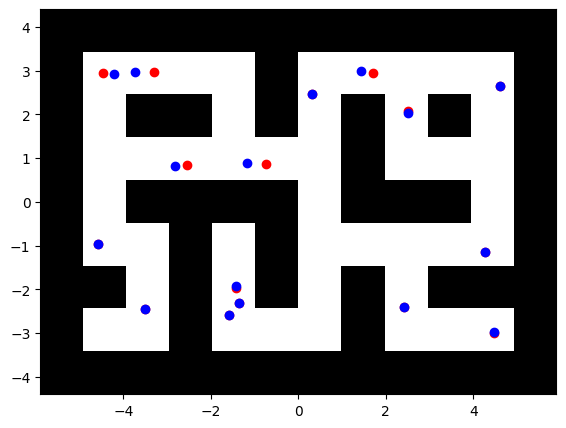

In [11]:
MINARI_POINTMAZE_LARGE_MAP = np.array(
    [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 
     [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], 
     [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1], 
     [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], 
     [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1], 
     [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], 
     [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1], 
     [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1], 
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
)
# Agent x,y bounds
XMIN = -4.9
XMAX = 4.9
YMIN = -3.4
YMAX = 3.4

# adjusted for the fact that the walls are beyond these min/max values
XMIN -= 1
XMAX += 1
YMIN -= 1
YMAX += 1

mask = np.zeros(shape=(10_000), dtype=bool)

for i in range(unique_u.size(0)):
    saved_idx = 0
    max_dist = float('-inf')
    for j in range(len(z)):
        sim = cos_sim(unique_u[i], z[j])
        if sim > max_dist: 
            max_dist = sim
            saved_idx = j
    mask[saved_idx] = True

true_cluster_pts = states[mask][:, :2]

clustered_states = states[unique_mask]
clustered_pts = clustered_states[:, :2]
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(MINARI_POINTMAZE_LARGE_MAP, cmap="gray_r",
           extent=(XMIN, XMAX, YMIN, YMAX))
axs.scatter(x=clustered_pts[:, 0], y=clustered_pts[:, 1], c="red")
axs.scatter(x=true_cluster_pts[:, 0], y=true_cluster_pts[:, 1], c="blue")


In [12]:
#cos sim matrix
u_Norm = torch.nn.functional.normalize(u, p=2, dim=1)

u_cos_sim = torch.matmul(u_Norm, u_Norm.T)
above_diag_cos_sim = u_cos_sim[torch.triu(torch.ones_like(u_cos_sim), diagonal=1).bool()]

In [13]:
# euclidean matrix 
euclidean = torch.cdist(u, u, p=2)
above_diag_euclidean = euclidean[torch.triu(torch.ones_like(u_cos_sim), diagonal=1).bool()]

Text(0.5, 1.0, 'Euclidean Distance Histogram')

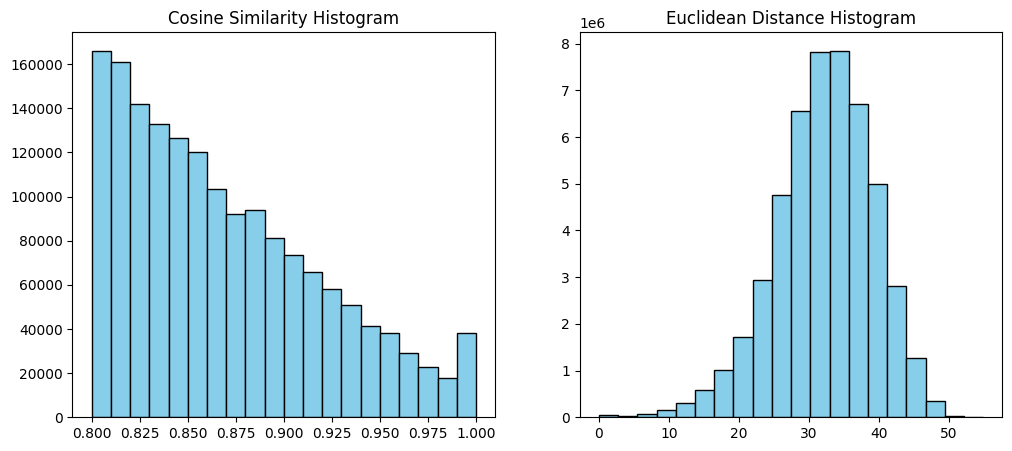

In [15]:
fig, axs = plt.subplots(1, 2, figsize= (12, 5)) 
axs[0].hist(x=above_diag_cos_sim, bins=20, range=[0.8, 1], color="skyblue", edgecolor="black")
axs[0].set_title("Cosine Similarity Histogram")
axs[1].hist(x=above_diag_euclidean, bins=20, color="skyblue", edgecolor="black")
axs[1].set_title("Euclidean Distance Histogram")

